# Who's actually protected by the Covid19 lockdown?

Welcome to the first Turing Data Story.

Our goal at Turing Data Stories is to produce educational data science content through the story telling medium.

Our stories begin with a question about a societal issue that is close to our hearts, and covers our entire analysis process in trying to answer it. From gathering and cleaning the data, to using it for data analysis.

Our hope that our stories will not only provide the reader with interesting insight into some key societal issues, but also to showcase the explanatory power of data science and enable the reader to try out some of these techniques themselves.

Each of our stories consists of a Jupyter notebook, which will contain all the code required to follow along with the analysis but also an explanation of our thought process and what the code is doing.

## Covid19 and deprivation

Everyone in the UK has been impacted by the Covid19 pandemic, from London to Manchester, Cardiff to Edinburgh. The virus has affected and taken many lives of people across society.

Back on the [23rd of March 2020](https://www.bbc.co.uk/news/uk-52012432), the UK Government announced various lockdown measures with the intention to limit the spread of the virus and reduce the number of Covid19 related deaths. These lockdown measures meant the temporary closure of many commercial shops and businesses, as well as the limiting of work based travel to only those jobs that could not be done at home.

**We are concerned that the impact of Covid19 has disproportionately affected certain groups of people, and that the lockdown measures have not been effective enough for those in the most deprived areas whose livelihoods may have required them to leave the house more frequently.**

There have been a number of [concerns](https://www.ft.com/content/301c847c-a317-4950-a75b-8e66933d423a) with Government Covid19 reporting, in particular with testing and mortality statistics. This motivates independent, open analysis to validate and expand on our understanding of our current state of the pandemic.

Earlier in June, the Office of National Statistics (ONS) [published a report](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsinvolvingcovid19bylocalareasanddeprivation/latest) exploring this exact question: to assess whether those living in the most deprived areas of the UK were disproportionately affected by Covid19. The report seems to confirm our fear - between the months of March to May 2020 those in the most deprived areas of the UK were more than twice as likely to die as a result of Covid19 than those in the least deprived areas.

There are two caveats that we have with the ONS analysis. The first is **reproducibility** - we want to confirm the ONS results by making analysis procedure open. The second caveat is the **time frame** of the ONS report. Between March and May represents the time when the lockdown was most severe, with measures relaxing from June onwards. We wonder whether the ONS analysis will continue to be relevant as lockdown eases. For this purpose, we wish to extend the ONS analysis to cover all available data.

Thus for our first story we ask:

**Have the Covid19 lockdown measures protected people equally across all socio-economic groups in society**

We have two main objectives

1) We want to replicate the ONS analysis using their provided data to ensure that we have all the inputs necessary to understand the problem.

2) We want to extend the ONS analysis to consider more time periods - representing the severity of the different stages of lockdown - to see how this affects people from different socio-economic groups.


### Key Metrics

Our analysis will involve exploring the relationship between the following key metrics:

- Covid19 mortality rates over time and across geographical regions.
- Index of multiple deprivation (IMD) by geographical region (see [definition](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/835115/IoD2019_Statistical_Release.pdf) and [explanation](https://en.wikipedia.org/wiki/Multiple_deprivation_index)).

### Data Sources

We will use the following ONS datasets:

- [Mortality count time series](https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/causesofdeath/datasets/deathregistrationsandoccurrencesbylocalauthorityandhealthboard)
- [IMD Rankings (England only)](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019)
- [Populations](https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationestimates%2fdatasets%2fpopulationestimatesforukenglandandwalesscotlandandnorthernireland%2fmid20182019laboundaries/ukmidyearestimates20182019ladcodes.xls)
- [Local Authority District Code Region Lookup Table](https://opendata.arcgis.com/datasets/3ba3daf9278f47daba0f561889c3521a_0.csv)
- [ONS Mortality and Depravation Data](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/deathsinvolvingcovid19bylocalareaanddeprivation)

In case any of the data sources become unavailable in the future, a download mirror is availible [here](https://drive.google.com/drive/folders/1NXp7DtBeCbTIv49_ngdgvQpQXaaB3f8F?usp=sharing).

For simplicity this study is only focusing on England. We understand the importance of investigating all of the regions of the UK. However due to the difference of lockdown measures across the nations of the UK, and also data compatibility issues between these region, an independent analysis is required for each nation. We warmly encourage the reader to replicate our analysis with the other nations.

### Analysis Outline

In this section we list the key steps of the analysis presented in this notebook.

1) Download and process data from multiple deprivation and Covid19 deaths.

2) Combining the different datasets into a single table by joining on geographical region.

3) Calculate age standardised mortality rates from mortality counts.

4) Replicate the ONS analysis, looking at mortality rate by region.

5) Visualise the distribution of Covid19 deaths across the UK.

6) Segment the data into during- and post-lockdown periods.

7) Explore at the relationship between our two key metrics (deprivation and mortality rates) in the different time periods.

# 🔧 Setup & Data Collation

🔧We begin by setting up our environment and importing various python libraries that we will be using for the analysis. 
In particular, `pandas` and `numpy` are key data science libraries used for data processing. `geopandas` will help us dealing with geospatial data. `matplotlib` and `seaborn` will help us visualise our data.

In [5]:
import os
import requests
from datetime import datetime
import zipfile

import numpy as np
import pandas as pd
import geopandas as gpd

from scipy.stats import spearmanr, pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
#sns.set_style('ticks')

🔧 Let's make some directories in which we can store the data we are going to download. 

In [6]:
# downloaded data goes here
downloaded_data_dir = 'data/downloaded'

# processed data goes here
derived_data_dirname = 'data/derived'

# create the directory if it does not already exist
os.makedirs(downloaded_data_dir, exist_ok=True)
os.makedirs(derived_data_dirname, exist_ok=True)

🔧 Here is a small helper function which will download files from a URL.

In [7]:
# This function can download data from a URL and then save it in a directory of our choice.
def download_file(url, filename):
    
    # if the file already exists, return without redownloading
    #if os.path.exists(filename):
    #    return
        
    # create the directory if it does not already exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # make the HTTP request
    r = requests.get(url, allow_redirects=True)

    # save file
    _ = open(filename, 'wb').write(r.content)


## Index of Multiple Deprivation (IMD)

🔧 Now let's download and process our deprivation data. This data provides a deprivation rank (lower rank meaning more deprived) for each LSOA.

### Download

In [8]:
# specify URL
url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/833970/File_1_-_IMD2019_Index_of_Multiple_Deprivation.xlsx'

# specify filename
filename = 'ONS_2019_Index_of_Multiple_Deprivation.xlsx'

# construct file path
filepath = os.path.join(downloaded_data_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

# read the relevant sheet
imd_df = pd.read_excel(filepath, sheet_name='IMD2019')

If we sort by deprivation rank, we can get an idea of the most / least deprived LSOAs.

In [9]:
imd_df.sort_values(by='Index of Multiple Deprivation (IMD) Rank')

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Rank,Index of Multiple Deprivation (IMD) Decile
21400,E01021988,Tendring 018A,E07000076,Tendring,1,1
12280,E01012673,Blackpool 010A,E06000009,Blackpool,2,1
12288,E01012681,Blackpool 006A,E06000009,Blackpool,3,1
12279,E01012672,Blackpool 013B,E06000009,Blackpool,4,1
12278,E01012671,Blackpool 013A,E06000009,Blackpool,5,1
...,...,...,...,...,...,...
17759,E01018293,South Cambridgeshire 012B,E07000012,South Cambridgeshire,32840,10
15715,E01016187,Bracknell Forest 002D,E06000036,Bracknell Forest,32841,10
30976,E01031773,Mid Sussex 008D,E07000228,Mid Sussex,32842,10
26986,E01027699,Harrogate 021A,E07000165,Harrogate,32843,10


### Derive Mean IMD Decile



At this point we want to join the two datasets together in order to explore the relationship between our two key metrics. 

For more information about the different geographical regions in the UK, read [this](https://data.gov.uk/dataset/ec39697d-e7f4-4419-a146-0b9c9c15ee06/output-area-to-lsoa-to-msoa-to-local-authority-district-december-2017-lookup-with-area-classifications-in-great-britain).

A problem is that the index of multiple deprivation comes with a geographical granularity at the LSOA level, whilst the Covid19 mortality counts come with a geographical granularity at the Local Authority District (LAD) level. This means that for one LAD there could be multiple LSOAs each with different indexes of multiple deprivation. 

Therefore we need to aggregate the LSOAs into LADs by averaging out the indexes of multiple deprivation.

First let's write some functions to help us.

In [10]:
def get_mean_IMD_rank(LAD_code):
    """
    TODO: map mean rank to [0,1] to make the number easier to understand.
    """
    # select relevant LSOAs
    LSOAs = imd_df[imd_df['Local Authority District code (2019)'] == LAD_code]
    
    # calculate mean IMD rank
    mean_IMD_rank = round(LSOAs['Index of Multiple Deprivation (IMD) Rank'].mean(), 2)
    std_IMD_rank = round(LSOAs['Index of Multiple Deprivation (IMD) Rank'].std(), 2)
 
    return mean_IMD_rank, std_IMD_rank

def get_mean_IMD_decile(LAD_code):
    """
    TODO: map mean rank to [0,1] to make the number easier to understand.
    """
    # select relevant LSOAs
    LSOAs = imd_df[imd_df['Local Authority District code (2019)'] == LAD_code]
    
    # calculate mean IMD rank
    mean_IMD_decile = round(LSOAs['Index of Multiple Deprivation (IMD) Decile'].mean(), 2)
    std_IMD_decile = round(LSOAs['Index of Multiple Deprivation (IMD) Decile'].std(), 2)
    
    return mean_IMD_decile, std_IMD_decile

Now we can use these functions to calculate the mean IMD decile in each Local Authority District.

In [11]:
LAD_codes = imd_df['Local Authority District code (2019)'].unique()
#mean_IMD_rank, std_IMD_rank = np.vectorize(get_mean_IMD_rank)(LAD_codes)
mean_IMD_decile, std_IMD_decile  = np.vectorize(get_mean_IMD_decile)(LAD_codes)

LAD_df = pd.DataFrame({'LAD Code': LAD_codes, 
                       'LAD Name': imd_df['Local Authority District name (2019)'].unique(),
                       #'Mean IMD Rank': mean_IMD_rank,
                       #'Std IMD Rank' : std_IMD_rank,
                       'Mean IMD decile': mean_IMD_decile,
                       'Std IMD decile': std_IMD_decile})

LAD_df = LAD_df.set_index('LAD Code')

Let's make a quick histogram of the mean IMD decile.

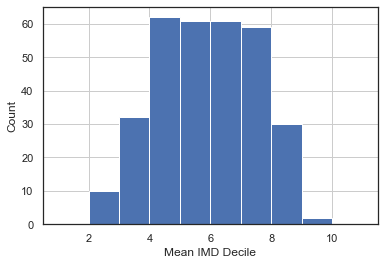

In [12]:
LAD_df['Mean IMD decile'].hist(range=(1,11), bins=10)
plt.xlabel('Mean IMD Decile')
plt.ylabel('Count')
plt.show()

As expected, we lose some information when aggregating IMD ranks in this way. The central part of the distribution is relatively flat, and we cannot differentiate well between LADs in this region.

Notice there are no Local Authority Districts that have a mean IMD decile of 1 or 10. This is due to the presence of variance inside each Local Authority District. As a consequence, there is no single LAD whose constituent LSOAs all have a IMD deciles of 1 (or 10). 

See the table below for the maximum and minimum mean IMD deciles. Note that Blackpool, the most deprived (on average) LAD in England, has a mean IMD decile of 2.41. This demonstrates that this LAD has some LSOAs that are not in the most deprived deciles. The opposite is true for the least deprived areas. The "Std IMD decile" column in the below table shows the level of variation of the IMD (measured by the standard deviation) within each LAD.

In [13]:
LAD_df.sort_values(by='Mean IMD decile')

,LAD Name,Mean IMD decile,Std IMD decile
LAD Code,,,
E06000009,Blackpool,2.41,1.58
E08000003,Manchester,2.54,1.84
E08000011,Knowsley,2.56,1.91
E09000002,Barking and Dagenham,2.68,1.01
E09000012,Hackney,2.74,1.11
...,...,...,...
E07000155,South Northamptonshire,8.78,1.32
E07000176,Rushcliffe,8.82,1.58
E07000005,Chiltern,8.86,1.51


### Derive Age Standardisation Weight

To account for the different population sizes in the different Local Area Districts, we want to use a mortality rate rather than an overall count. When we do this we convert a count into a rate per 100,000 people. Furthermore, we want to account for differences in the age distributions of the different LADs in order to make a valid comparison between the different geographic areas. An age standardised rate allows for this comparison. Ideally we would calculate this rate directly from the data, but as our mortality over time dataset does not contain information about age, we instead will need to extract a standardisation factor from a different dataset.

The [dataset](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/deathsinvolvingcovid19bylocalareaanddeprivation) we will use to do this comes from the ONS study on COVID-19 and deprivation. We will use it to derive a standardisation factor which will allow us to convert our mortality counts into an age and population standardise mortality rate. This mortality rate is a European standard (2013 ESP). As we mentioned, we cannot calculate the factor directly as our mortality over time dataset does not include age information, so this reverse engineering is the best we can do. 

For more information on how the mortality rate is calculated, [see here](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/methodologies/userguidetomortalitystatisticsjuly2017#death-rates-ratios-and-standardisation). Simply put, this is the formula that we are assuming approximates the relationship between the age standardised rate and the mortality count:

age standardised mortality rate = standardisation factor * mortality count

:warning: The above procedure is not ideal because it assumes that the distribution of ages of those who died inside each Local Area District is constant in time, and therefore the standardisation factor we derive in one dataset (which doesn't have information about time) can be applied to the other (which has information about time).

First, let's download and read the data.

In [14]:
# download the ONS data from the deprivation study
url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fdeathsinvolvingcovid19bylocalareaanddeprivation%2f1march2020to17april2020/referencetablesdraft.xlsx'

# specify filename
filename = 'ONS_age_standarisation_April2020.xlsx'

# construct file path
filepath = os.path.join(downloaded_data_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

# read the relevant sheet
age_rate_df = pd.read_excel(filepath, sheet_name='Table 2', header=3)

Do some minor selection and reformatting of the DataFrame.

In [15]:
# data if given for many categories and regios, lets choose the inclusive gender, and the unitary authority levels
age_rate_persons_df = age_rate_df[age_rate_df['Sex']=='Persons'] 

# rename columns
age_rate_persons_df.columns = ['Sex', 'Geography type', 'LAD Code', 'Area name', 'All causes Deaths',
       'All causes Rate','' ,'All causes Lower CI', 'All causes Upper CI','' ,'COVID-19 Deaths',
       'COVID-19 Rate', '','COVID-19 Lower CI', 'COVID-19 Upper CI' ]

# remove anomalous row (Isles of Scilly) without numerical data
age_rate_persons_df = age_rate_persons_df[age_rate_persons_df['All causes Rate'] != ':']
age_rate_persons_df = age_rate_persons_df[age_rate_persons_df['COVID-19 Rate'] != ':']

age_rate_persons_df.head()

,Sex,Geography type,LAD Code,Area name,All causes Deaths,All causes Rate,,All causes Lower CI,All causes Upper CI,,COVID-19 Deaths,COVID-19 Rate,,COVID-19 Lower CI,COVID-19 Upper CI
1,Persons,Unitary Authority,E06000001,Hartlepool,154,170.7,NaN,143.5,197.8,NaN,29,31,NaN,20.7,44.5
2,Persons,Unitary Authority,E06000002,Middlesbrough,289,256,NaN,226.1,286,NaN,89,79,NaN,63.2,97.6
3,Persons,Unitary Authority,E06000003,Redcar and Cleveland,215,142.6,NaN,123.5,161.8,NaN,40,26.5,NaN,18.9,36.2
4,Persons,Unitary Authority,E06000004,Stockton-on-Tees,297,167,NaN,147.8,186.1,NaN,38,21,NaN,14.8,28.9
5,Persons,Unitary Authority,E06000005,Darlington,169,151.5,NaN,128.6,174.4,NaN,26,22.9,NaN,15,33.7



Let us now calculate the factor by which we need to multiply the count of deaths to derive the age-standardised mortality rate per 100,000 habitants.

In [16]:
# derive standardisation factors
age_rate_persons_df['All causes rate factor'] = (
    age_rate_persons_df['All causes Rate'] / age_rate_persons_df['All causes Deaths'] )

age_rate_persons_df['COVID-19 rate factor'] = (
    age_rate_persons_df['COVID-19 Rate'] / age_rate_persons_df['COVID-19 Deaths'] )

# drop columns
age_rate_persons_df = age_rate_persons_df[['LAD Code', 'All causes rate factor', 'COVID-19 rate factor']]

In [17]:
LAD_df = LAD_df.reset_index()
LAD_df = LAD_df.merge(age_rate_persons_df, on='LAD Code', how='inner')
LAD_df = LAD_df.set_index('LAD Code')

Let's save the standardisation factors for each LAD, stored in the DataFrame `LAD_df`, so that we can easily use them later. 

In [18]:
# create filename
LAD_df_filename = 'Local_Authority_District_Lookup.csv'
LAD_df_filepath = os.path.join(derived_data_dirname, LAD_df_filename)

# write to csv
LAD_df.to_csv(LAD_df_filepath, index=False)

## Mortality Counts

Now we are ready to download the main dataset that we will be analysing: the number of COVID-19 and non COVID-19 deaths across time and place.

### Download and Format

First, let's download the ONS dataset containing mortality counts by week and Local Authority District.

In [19]:
# specify URL
url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fhealthandsocialcare%2fcausesofdeath%2fdatasets%2fdeathregistrationsandoccurrencesbylocalauthorityandhealthboard%2f2020/lahbtablesweek35.xlsx'

# specify filename
filename = 'ONS_COVID_Mortality_Counts.xlsx'

# construct file path
filepath = os.path.join(downloaded_data_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

In [20]:
# specify the sheet of the excel file we want to read
sheet_name = 'Occurrences - All data'

# read the sheet into a pandas DataFrame
mortality_df = pd.read_excel(filepath, sheet_name=sheet_name, header=3)

Let's quickly check if all the LADs are represented in both datasets so that we can join the IMD rank with the mortality information for each LAD.

In [21]:
not_in_imd = set(mortality_df['Area code']) - set(imd_df['Local Authority District code (2019)'])
not_in_mortality = set(imd_df['Local Authority District code (2019)']) - set(mortality_df['Area code'])
print('There are', len(not_in_mortality), 'codes in the IMD dataset but not in the mortality dataset.')
print('There are', len(not_in_imd), 'codes in the mortality dataset but not in the IMD dataset.')

There are 4 codes in the IMD dataset but not in the mortality dataset.
There are 30 codes in the mortality dataset but not in the IMD dataset.


We have 346 LAD codes in the mortality data set, and only 317 in the IMD dataset. Upon closer inspection, it turned out that IMD dataset does not contain any Welsh entries (as the IMD ranking is defined for England only). Additionally, the mortality dataset contains a single entry for Buckinghamshire, a new unitary authority in 2020 (E06000060). The IMD dataset, meanwhile, contains 4 LAD codes for Buckinghamshire. We will have to drop these anomalous locations from the analysis for now. 

In [22]:
# extract those LAD codes which are present in the mortality dataset but not the IMD dataset (Wales)
missing_LAD_codes_df = mortality_df[~mortality_df['Area code'].isin(imd_df['Local Authority District code (2019)'])]
missing_LAD_codes = missing_LAD_codes_df['Area code'].unique()

# filter by common LAD codes
mortality_df = mortality_df[~mortality_df['Area code'].isin(missing_LAD_codes)]

Furthermore, the age standardisation factor derived previously was not able to be derived for one LAD (the Isles of Scilly). Let's drop that now too to avoid any problems later down the line.

In [23]:
# remove LADs from the mortality DataFrame if we do not have an entry for them in the LAD_df
mortality_df = mortality_df[mortality_df['Area code'].isin(LAD_df.index)]

Finally, since we are interested in looking at the effect of COVID-19 and the lockdown policies on the working population, we can remove deaths that took place in care homes or hospices.

In [24]:
# select only deaths outside of care homes and hospices
mortality_df = mortality_df[(mortality_df['Place of death']!='Care home') & 
                            (mortality_df['Place of death']!='Hospice')]

# to instead select only deaths in care homes or hospices, use this line:
#mortality_df = mortality_df[(mortality_df['Place of death']=='Care home') | 
#                            (mortality_df['Place of death']=='Hospice')]

The mortality data starts from Wednesday 1st Jan 2020. Let's use that fact to convert the supplied week numbers into a date.

In [25]:
# first day of 2020 is a Wednesday
mortality_df['Date'] = [datetime.strptime(f'2020 {n-1} 3', '%Y %W %w').strftime('%Y-%m-%d') 
                        for n in mortality_df['Week number']]

# drop week number column
mortality_df = mortality_df.drop(columns='Week number')

Finally, we can take a random sample of 5 rows from the DataFrame to check everything looks okay, and to get an idea of its structure.

In [26]:
mortality_df.sample(n=5)

,Area code,Geography type,Area name,Cause of death,Place of death,Number of deaths,Date
134492,E07000229,Local Authority,Worthing,COVID 19,Home,0,2020-08-12
131977,E06000023,Local Authority,"Bristol, City of",All causes,Elsewhere,0,2020-08-12
1469,E07000102,Local Authority,Three Rivers,All causes,Other communal establishment,0,2020-01-01
51272,E07000137,Local Authority,East Lindsey,COVID 19,Home,0,2020-03-25
23173,E07000214,Local Authority,Surrey Heath,All causes,Elsewhere,0,2020-02-05


If you want to reproduce the results from the [ONS report](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsinvolvingcovid19bylocalareasanddeprivation/latest)
uncomment these lines.

In [27]:
#mortality_df = mortality_df[mortality_df['Date'] > '2020-03-01']
#mortality_df = mortality_df[mortality_df['Date'] < '2020-04-18']


## Download Local Area District to Region Lookup Table

As in the ONS report, a nice plot to make is the total number of mortalities in each region of England (regions are composed of many LADs, for example the West Midlands). To do this, we need to know which LADs belong to which regions. Let's download this data now from the following website: https://geoportal.statistics.gov.uk/datasets/local-authority-district-to-region-april-2019-lookup-in-england.

In [28]:
# specify URL
url = 'https://opendata.arcgis.com/datasets/3ba3daf9278f47daba0f561889c3521a_0.csv'

# specify filename
filename = 'LAD_Code_Region_Lookup.csv'

# construct file path
filepath = os.path.join (downloaded_data_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

# read the relevant sheet
LAD_code_region_lookup_df = pd.read_csv(filepath, index_col='FID').set_index('LAD19CD')

Taking a look at the data, we can see that the index "LAD19CD" contains our familiar LAD code, and the column "RGN12NM" gives us the name of the region in which that LAD is located. Perfect!

In [29]:
LAD_code_region_lookup_df.head()

,LAD19NM,RGN19CD,RGN19NM
LAD19CD,,,
E09000001,City of London,E12000007,London
E06000054,Wiltshire,E12000009,South West
E09000002,Barking and Dagenham,E12000007,London
E09000003,Barnet,E12000007,London
E09000004,Bexley,E12000007,London


## Split Data Into Different Time Periods

Now, the final step before we can produce and understand some results, is to split our dataset into different time periods. As mentioned in the introduction, we want to compare COVID-19 mortality before and after lockdown polices were put in place. Within each time period, we sum over all deaths, and add the IMD decile for each LAD. Finally we also include Region information.

Let's write a function to sum the mortality data over time to get the total number of deaths. Then, we'll reformat the DataFrame to separate COVID-19 and non COVID-19 deaths. Finally, we'll use the table downloaded in the previous section to get the Region name for each LAD. The function combines information from all the previous DataFrames and produces a DataFrame with everything we need to do our analysis. 

Now we are finished with all of the processing steps and we are ready for the fun part: analysing the data.

In [30]:
def filter_date_and_aggregate(df, date_range=None):
    """
    The function:
    - Selects dates that are inside the supplied date range.
    - Sums over time in this date range.
    - Separates COVID-19 vs non COVID-19 deaths.
    - Decorates rows with area and region name columns.
    - Calculates the standardised mortality rate using previously calculated factors.
    - Pulls in the mean IMD decile as previously calculated.
    """
    
    # filter dates
    if date_range:
        df = df[(df['Date'] >= date_range[0]) & (df['Date'] < date_range[1])]
    
    # sum over time
    df = df.groupby(by=['Area code', 'Cause of death']).sum()
    df = df.reset_index(level=[-1])

    # seperate out all deaths and COVID deaths as their own columns
    df = df.pivot(columns='Cause of death', values='Number of deaths')
    df.columns.name = ''

    # rename columns
    df = df.rename(columns={'All causes': 'Total deaths', 'COVID 19': 'COVID deaths'})

    # add non-COVID deaths as column
    df['Non COVID deaths'] = df['Total deaths'] - df['COVID deaths']

    # add area names
    df['Area name'] = LAD_df.loc[df.index]['LAD Name']

    # add region names
    df['Region name'] = LAD_code_region_lookup_df.loc[df.index]['RGN19NM']
    
    # Calculate the rate per 100k using the age-standardisation factor estimated previously
    df['COVID-19 rate'] = (LAD_df.loc[df.index]['COVID-19 rate factor'] * df['COVID deaths']).astype(float)
    df['All causes rate'] = (LAD_df.loc[df.index]['All causes rate factor'] * df['Total deaths']).astype(float)
    
    # import mean IMD rank
    df['Mean IMD decile'] = LAD_df['Mean IMD decile']
    
    return df

In [31]:
# sum over "Place of death" column
mortality_sum_df = mortality_df.groupby(by=['Area code', 'Date', 'Cause of death']).sum().reset_index()

First, let's agreggate the data without splitting into different time periods.

In [32]:
# this line performs the agreggation step (summing mortality over time).
# and also includes information about deprivation, no date filtering yet.
total_deaths_df = filter_date_and_aggregate(mortality_sum_df)

Now we can split up the data into three periods. The first period is from January 1st to April 7th - 16 days from the beginning of lockdown. The second period runs from April 7th to June 1st - 16 days after the stay at home order was lifted. The final period runs from June 1st to August 28th.

We use a time delay of 16 days after key policy decisions to account for the time lag between onset of the disase and death. The number was taken from this study: https://www.bmj.com/content/368/bmj.m1091

In [33]:
# first date range
first_date_range = ('2020-01-01', '2020-04-07')
first_df = filter_date_and_aggregate(mortality_sum_df, first_date_range)
first_df['period'] = 1

# second date range
second_date_range = ('2020-04-07', '2020-06-01')
second_df = filter_date_and_aggregate(mortality_sum_df, second_date_range)
second_df['period'] = 2

# second date range
third_date_range = ('2020-06-01', '2020-08-28')
third_df = filter_date_and_aggregate(mortality_sum_df, third_date_range)
third_df['period'] = 3

In [34]:
print('Total deaths in before lockdown period:\t', first_df['COVID deaths'].sum())
print('Total deaths in during lockdown period:\t', second_df['COVID deaths'].sum())
print('Total deaths in after lockdown period:\t', third_df['COVID deaths'].sum())

Total deaths in before lockdown period:	 6521
Total deaths in during lockdown period:	 24179
Total deaths in after lockdown period:	 3217


Here we can also choose to divide the rate by the number of days in the time period, to compute the age standardised mortality rate per day.

In [35]:
def get_num_days(date_range):
    d0 = datetime.strptime(date_range[1], '%Y-%m-%d')
    d1 = datetime.strptime(date_range[0], '%Y-%m-%d')
    return (d0 - d1).days

full_date_range = ('2020-01-01', '2020-08-28')
total_deaths_df['All causes rate'] = total_deaths_df['All causes rate'] / get_num_days(full_date_range)
total_deaths_df['COVID-19 rate'] = total_deaths_df['COVID-19 rate'] / get_num_days(full_date_range)

first_df['All causes rate'] = first_df['All causes rate'] / get_num_days(first_date_range)
first_df['COVID-19 rate']   = first_df['COVID-19 rate']   / get_num_days(first_date_range)

second_df['All causes rate'] = second_df['All causes rate'] / get_num_days(second_date_range)
second_df['COVID-19 rate']   = second_df['COVID-19 rate']   / get_num_days(second_date_range)

third_df['All causes rate'] = third_df['All causes rate'] / get_num_days(third_date_range)
third_df['COVID-19 rate']   = third_df['COVID-19 rate']   / get_num_days(third_date_range)

In [36]:
# recombining with the additional column
all_df = pd.concat([first_df,second_df, third_df])

# Study 1 - Regional Mortality Counts & Rates

Our first objective was to reproduce the ONS analysis to ensure that we have all the pieces we need to understand the problem. The first plots that we will replicate compare COVID-19 mortality across the different regions in England (Figures 1 & 2 in the ONS analysis).

## Total Mortalities by Region

For Figure 1, we will produce a stacked bar chart showing the mortality count (split up into COVID-19 and non COVID-19 deaths) for each Region in England.

Summing over region and sorting the values, we are almost ready to make the plot.

In [44]:
# sum over LADs in each region
total_deaths_by_region_df = total_deaths_df.groupby(by='Region name').sum()

# sort ascending
total_deaths_by_region_df = total_deaths_by_region_df.sort_values(by='Total deaths', ascending=True)

Finally, let's write the code to actually make the plot.

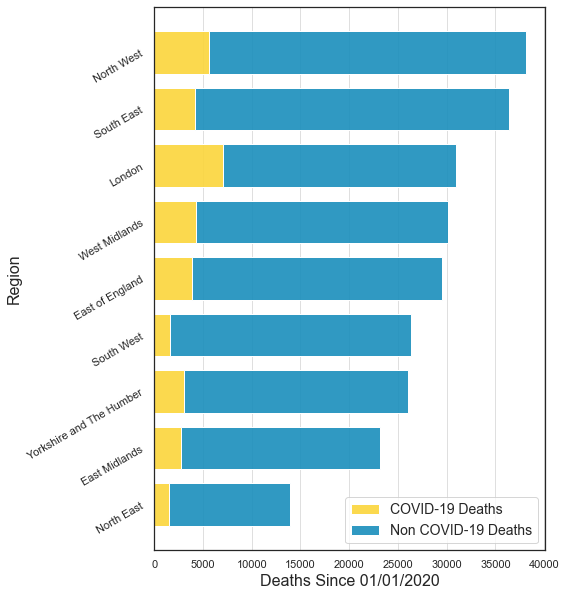

In [46]:
# region names
xs = total_deaths_by_region_df.index

# mortality counts
non_covid_deaths = total_deaths_by_region_df['Non COVID deaths']
covid_deaths = total_deaths_by_region_df['COVID deaths']

# set bar width
width = 0.75

# colors similar to ONS
covid_color = (251/255, 213/255, 59/255, 0.9)
noncovid_color = (25/255, 142/255, 188/255, 0.9)

# create a figure and plot data
plt.figure(figsize=(7,10))
p1 = plt.barh(xs, covid_deaths, width, color=covid_color, label='COVID-19 Deaths')
p2 = plt.barh(xs, non_covid_deaths, width, left=covid_deaths, color=noncovid_color, label='Non COVID-19 Deaths')


# label axes
plt.xlabel('Deaths Since 01/01/2020', fontsize=16)
plt.ylabel('Region', fontsize=16)
plt.yticks(rotation=30)

# add vertical grid lines
plt.gca().xaxis.grid(True, linestyle='-', which='major', color='grey', alpha=.25)

# show legend and plot
plt.legend(fontsize=14)
plt.show()

There it is! A lot of work but now we can already begin to try and understand what this data is telling us. For example, some conclusions:
- For all regions, the number of COVID-19 deaths is smaller than the number of non COVID-19 deaths.
- The number of deaths varies a lot between different regions. This can be due to the fact that there are different numbers of people living in each region (for example, there are more people living in the South East than there are in London). On top of that, we know that older people have a higher risk of dying after contracting COVID-19, and as the age distributions are different for different regions, this can also affect the overall number of deaths.

## Standardised Mortality Rate by Region

To account for the varying population sizes and age distributions, let's look at the age-standardised mortality rates per 100,000 people, standardised to the 2013 European Standard Population. Age-standardised mortality rates allow for differences in the age structure of populations and therefore allow valid comparisons to be made between geographical areas, the sexes and over time. 							

In [47]:
# calculate the mean rate per region and sort
total_rates_df_by_region = total_deaths_df.groupby(by='Region name', as_index=False).agg('mean')
total_rates_df_by_region = total_rates_df_by_region.sort_values(by='All causes rate', ascending=True)

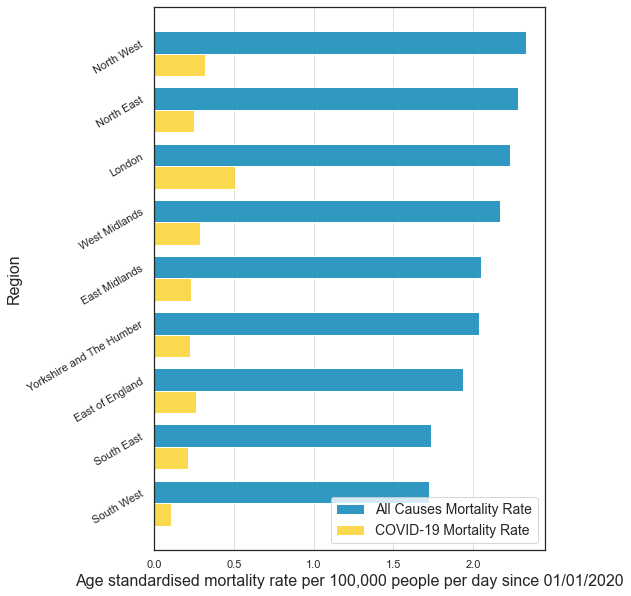

In [48]:
# region names
x_labels = total_rates_df_by_region['Region name']
xs = np.array(range(len(x_labels)))

# mortality counts
non_covid_rate = total_rates_df_by_region['All causes rate']
covid_rate = total_rates_df_by_region['COVID-19 rate']

# set bar width
width = 0.4

# create a figure and plot data
plt.figure(figsize=(7,10))
p2 = plt.barh(xs+0.2, non_covid_rate, width, color=noncovid_color, label='All Causes Mortality Rate', tick_label=x_labels)
p1 = plt.barh(xs-0.2, covid_rate, width, color=covid_color, label='COVID-19 Mortality Rate')

# label axes
plt.xlabel('Age standardised mortality rate per 100,000 people per day since 01/01/2020', fontsize=16)
plt.ylabel('Region', fontsize=16)
plt.yticks(rotation=30)

# add vertical grid lines
plt.gca().xaxis.grid(True, linestyle='-', which='major', color='grey', alpha=.25)

# show legend and plot
plt.legend(fontsize=14, loc='lower right')
plt.show()

Note that as we plot the rates, we switch from a stacked bar chart (showing counts of COVID-19 and non COVID-19 mortalities), to two bar charts side by side (showing the COVID-19 mortality rate, and the all causes mortality rate). Even with this caveat in mind, when looking at the chart we see it tells a different story to the previous plot. For example, in the previous plot, the South East had the highest number of total deaths, but looking at the standardised rates in this plot we see that it is ranked second from the bottom. This shows that the raw mortality counts do not tell the whole story, and so we cannot rely solely on them to make meaningful comparisons between different Regions.

# Study 2 - Mortality by Deprivation

We can now study the relationship between COVID-19 mortality and deprivation. To do this we will make some plots showing the standardised mortality rate as a function of the mean IMD decile for each LAD in England. Recall that the rate has been normalised by the number of days in each time period, so that they are comparable.

In the plots, you will see the $y$ axis labelled with "Standardised Mortality Rate". In fact, this rate is the **age standardised count of deaths observed per 100,000 people per day**.

In [78]:
# define a function that we can use to calculate the correlation and slope of a linear fit
def get_corr_and_slope(xs, ys):
    
    # calculate the correlation coefficient
    corr = round(pearsonr(xs, ys)[0], 2)
    
    # calcualte the slope of a linear fit
    slope = round(np.polyfit(xs, ys, 1)[0], 2)
    
    return corr, slope

## Comparing All Causes and COVID-19 Mortality Rates

To get started, let's overlay the mortality rates for all causes of death and COVID-19 on the same plot.

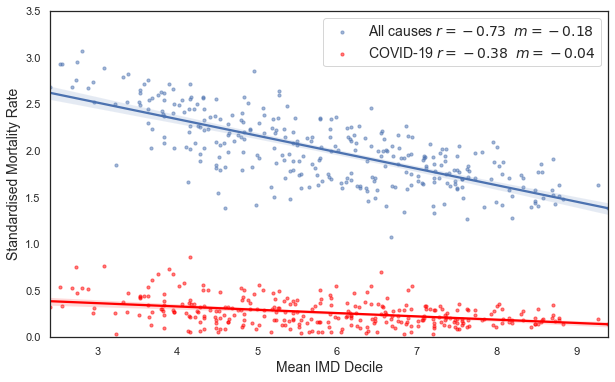

In [82]:
# plot formatting
po = {'s': 10, 'alpha':0.5}

# select data
IMD_decile = total_deaths_df['Mean IMD decile']
all_causes_rate = total_deaths_df['All causes rate']
covid_rate = total_deaths_df['COVID-19 rate']

# calcualte correlations and slopes
ac_stats = get_corr_and_slope(IMD_decile, all_causes_rate)
c19_stats = get_corr_and_slope(IMD_decile, covid_rate)

# make plots
plt.figure(figsize=(10,6))
sns.regplot(x=IMD_decile, y=all_causes_rate, label=f'All causes $r={ac_stats[0]}$  $m={ac_stats[1]}$', scatter_kws=po)
sns.regplot(x=IMD_decile, y=covid_rate, color='red', label=f'COVID-19 $r={c19_stats[0]}$  $m={c19_stats[1]}$', scatter_kws=po)

# format plot
plt.ylabel('Standardised Mortality Rate', fontsize=14)
plt.xlabel('Mean IMD Decile', fontsize=14)
plt.legend(fontsize=14); plt.ylim((0, 3.5))
plt.show()

Recall that the lower the mean IMD rank in each LAD, the more deprived the area is. This plot tells us:
- We observe a significant negative correlation between death rates form all causes and social deprivation (as measured by IMD decile).
- The observed correlation between COVID-19 death rates and social deprivation is weaker, but still present.

TODO: link article explaining strong all causes correlation.

## Time Periods

We are now finally ready to investigate the relationship between mortality and deprivation in the different periods of lockdown. The three periods we defined are:
- **Before lockdown**: January 1st to April 7th
- **Duing lockdown**: April 7th to June 1st
- **After lockdown**: June 1st to August 28th

We will look at this relationship for all causes of death, and for COVID-19 deaths separately.

### All Causes

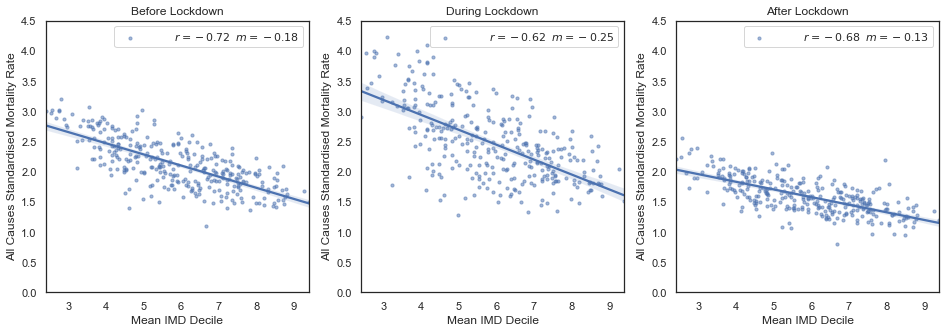

In [85]:
ymax = 4.5
plt.figure(figsize=(16,5))

# calcualte correlations and slopes
pre_stats = get_corr_and_slope(first_df['Mean IMD decile'], first_df['All causes rate'])
dur_stats = get_corr_and_slope(second_df['Mean IMD decile'], second_df['All causes rate'])
pos_stats = get_corr_and_slope(third_df['Mean IMD decile'], third_df['All causes rate'])

plt.subplot(131)
plt.title('Before Lockdown')
sns.regplot(x='Mean IMD decile', y='All causes rate', data=first_df, label=f"\t$r={pre_stats[0]}$  $m={pre_stats[1]}$", scatter_kws=po)
plt.xlabel('Mean IMD Decile', fontsize=12)
plt.ylabel('All Causes Standardised Mortality Rate', fontsize=12)
plt.legend(); plt.ylim((0, ymax))

plt.subplot(132)
plt.title('During Lockdown')
sns.regplot(x='Mean IMD decile', y='All causes rate', data=second_df, label=f"\t$r={dur_stats[0]}$  $m={dur_stats[1]}$", scatter_kws=po)
plt.xlabel('Mean IMD Decile', fontsize=12)
plt.ylabel('All Causes Standardised Mortality Rate', fontsize=12)
plt.legend(); plt.ylim((0, ymax))

plt.subplot(133)
plt.title('After Lockdown')
sns.regplot(x='Mean IMD decile', y='All causes rate', data=third_df, label=f"\t$r={pos_stats[0]}$  $m={pos_stats[1]}$", scatter_kws=po)
plt.xlabel('Mean IMD Decile', fontsize=12)
plt.ylabel('All Causes Standardised Mortality Rate', fontsize=12)
plt.legend(); plt.ylim((0, ymax))

plt.show()

After splitting the data into the three time periods, we that the the negative correlation persists for each period, but has different strengths. The potential reasons for the differences in strength are numerous.

The middle plot contains the peak in the number of COVID-19 deaths, whereas the plots on the side contain deaths mostly from causes other than COVID-19. This can explain the interesting effect that we observe in the middle plot: the correlation is lower (the variance is lager), but the slope of the linear fit is steeper (TODO confirm this).

### COVID-19

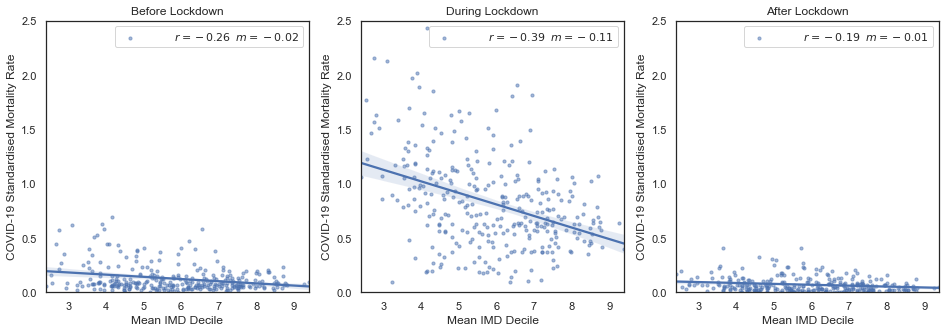

In [88]:
ymax = 2.5
plt.figure(figsize=(16,5))

# calcualte correlations and slopes
pre_stats = get_corr_and_slope(first_df['Mean IMD decile'], first_df['COVID-19 rate'])
dur_stats = get_corr_and_slope(second_df['Mean IMD decile'], second_df['COVID-19 rate'])
pos_stats = get_corr_and_slope(third_df['Mean IMD decile'], third_df['COVID-19 rate'])

plt.subplot(131)
plt.title('Before Lockdown')
sns.regplot(x='Mean IMD decile', y='COVID-19 rate', data=first_df, label=f"\t$r={pre_stats[0]}$  $m={pre_stats[1]}$", scatter_kws=po)
plt.xlabel('Mean IMD Decile', fontsize=12)
plt.ylabel('COVID-19 Standardised Mortality Rate', fontsize=12)
plt.legend(); plt.ylim((0, ymax))

plt.subplot(132)
plt.title('During Lockdown')
sns.regplot(x='Mean IMD decile', y='COVID-19 rate', data=second_df, label=f"\t$r={dur_stats[0]}$  $m={dur_stats[1]}$", scatter_kws=po)
plt.xlabel('Mean IMD Decile', fontsize=12)
plt.ylabel('COVID-19 Standardised Mortality Rate', fontsize=12)
plt.legend(); plt.ylim((0, ymax))

plt.subplot(133)
plt.title('After Lockdown')
sns.regplot(x='Mean IMD decile', y='COVID-19 rate', data=third_df, label=f"\t$r={pos_stats[0]}$  $m={pos_stats[1]}$", scatter_kws=po)
plt.xlabel('Mean IMD Decile', fontsize=12)
plt.ylabel('COVID-19 Standardised Mortality Rate', fontsize=12)
plt.legend(); plt.ylim((0, ymax))

plt.show()

This plot is interesting, as it suggests that although the correlation is stronger, the fit line is not steeper. (Correlation does not give you any information about the slope, just the amount of noise in the linear relationship).

# Extra Map Visualistaions

While looking at numbers or rates of mortality at the region level can give us an overview, it would be interesting to see what is happening at the more detailed level of each LAD. In this section, we will visualise the previous study, at a higher granularity, using a map. (Heavily based on code from https://github.com/DavidBeavan/coronavirus_covid-19).



What we are seeing

London, urban, people traveling, airports
South West, rural, less movement of the population, less traveling

### [Section Unused] Convert to Time Series

For now, let's sum the number of deaths over all places of death. It will also be useful to separate the "all causes" mortality counts and the "covid" mortality counts.

In [ ]:
# sum over "Place of death" column
mortality_sum_df = mortality_df.groupby(by=['Area code', 'Date', 'Cause of death']).sum().reset_index()

# separate "all causes" and "covid" mortality counts
all_causes_df = mortality_sum_df[mortality_sum_df['Cause of death'] == 'All causes']
covid_df = mortality_sum_df[mortality_sum_df['Cause of death'] == 'COVID 19']

Create a new DataFrame, where we have an index corresponding to LAD Area code, and columns corresponding to dates. The entries in the DataFrame correspond to total number of deaths for that week in that LAD. Let's do this for all causes first.

In [ ]:
# create new DataFrame
all_cause_mortality_ts_df = pd.DataFrame()
all_cause_mortality_ts_df.index.name = 'Area code'

# loop over all causes mortality summed DataFrame
for index, row in all_causes_df.iterrows():
    
    # if we haven't added this area code yet, add it now
    if index not in all_causes_df.index:
        all_cause_mortality_ts_df.loc[row['Area code']] = {}
    
    # add the mortality count
    all_cause_mortality_ts_df.loc[row['Area code'], row['Date']] = row['Number of deaths']

Same again for Covid deaths.

In [ ]:
# create new DataFrame
covid_mortality_ts_df = pd.DataFrame()
covid_mortality_ts_df.index.name = 'Area code'

# loop over all causes mortality summed DataFrame
for index, row in covid_df.iterrows():
    
    # if we haven't added this area code yet, add it now
    if index not in covid_df.index:
        covid_mortality_ts_df.loc[row['Area code']] = {}
    
    # add the mortality count
    covid_mortality_ts_df.loc[row['Area code'], row['Date']] = row['Number of deaths']

In [ ]:
covid_mortality_ts_df.head()

First, weed to download a shapefile which defines the geographical boundaries of the different local authorities in England.

In [ ]:
# specify URL
url = 'https://opendata.arcgis.com/datasets/1d78d47c87df4212b79fe2323aae8e08_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D'

# specify filename
filename = 'lad_boundaries.zip'

# construct file path
utla_download_dir = os.path.join(downloaded_data_dir, 'lad_boundaries')
filepath = os.path.join(utla_download_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

# unzip
myzipfile = zipfile.ZipFile(filepath)
myzipfile.extractall(utla_download_dir)

Next, we can load the shapefile into a GeoPandas DataFrame and extract the pieces we need.

In [ ]:
# Load Local Authority District boundary shapefile
lad_boundaries_df = gpd.read_file(os.path.join(utla_download_dir, 
                        'Local_Authority_Districts__December_2019__Boundaries_UK_BFC.shp'))

# Remove Scotland and NI (for now, this is only parsing England data)
lad_boundaries_df = lad_boundaries_df[~lad_boundaries_df['lad19cd'].str.contains('^[SN]')]

# Remove Wales (for now, this is only parsing England data)
lad_boundaries_df = lad_boundaries_df[lad_boundaries_df['lad19nmw'].isnull()]

# Drop unused columns
lad_boundaries_df.drop(columns=['objectid', 'bng_e', 'lad19nmw', 'st_areasha', 
                      'bng_n', 'long', 'lat', 'st_lengths', 'lad19nm'], inplace=True)

# Index on ctyua19cd AKA region code
lad_boundaries_df.set_index('lad19cd', inplace=True)
lad_boundaries_df.index.name = 'Area code'

# remove LADs from the bondaries DataFrame if we do not have an entry for them in the LAD_df
lad_boundaries_df = lad_boundaries_df[lad_boundaries_df.index.isin(LAD_df.index)]

Let's add the boundary data to the mortality DataFrame we constructed earlier. We have to perform the join from `lad_boundaries_df` so that the resulting DataFrame is still a `GeoPandas` DataFrame.

In [ ]:
#mortality_geom_df = lad_boundaries_df.join(total_deaths_df)
map_period1_df = lad_boundaries_df.join(first_df)
map_period2_df = lad_boundaries_df.join(second_df)

Here we write a simple function to actually make the map plot.

In [ ]:
def show_map(df, variable, title, cmap, ax, limits=None):

    # Zoom in to limits, if given
    if limits:
        ax.set_xlim(limits[0])
        ax.set_ylim(limits[1])


    # Plot map
    df.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='gray', vmin=0, vmax=100)

    # Remove the axis
    ax.axis('off')

    # Add title
    ax.set_title(title, fontdict={
                 'fontsize': 'xx-large', 'fontweight': 'bold'})

    # Add attributions
    #ax.annotate('Code: David Beavan Twitter:@DavidBeavan GitHub:https://github.com/DavidBeavan/coronavirus_covid-19\nPopulation estimates mid-2018\nSource: Office for National Statistics licensed under the Open Government Licence\nContains OS data © Crown copyright and database right 2019',
    #            xy=(0.02, .08), xycoords='figure fraction',
    #            horizontalalignment='left', verticalalignment='top',
    #            fontsize='medium', color='black')

In [ ]:
# make mortality rate map
# Prep plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), facecolor='LightGray')
cmap = 'jet'

show_map(map_period1_df, map_period1_df['COVID-19 rate'],
         'COVID-19 Mortality Rate (1st Jan to 13th Apr)', cmap, ax1)
show_map(map_period2_df, map_period2_df['COVID-19 rate'],
         'COVID-19 Mortality Rate (13th Apr to 1st Jul)', cmap, ax2)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
sm._A = []
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

Comment about evolution.
- the virus spread out of from the big cities
- we have more deaths overall in period 2 so map is brighter overall
-  a rise in the more industrial parts of the country (i.e. the north). My hypothesis, they are the places where work is hands-on and less knowledge based, so people are mixing more?

1. the virus came skiing from Italy into the big cities
2. Cities lockdown effectively reducing transmission in the first weeks
3. The virus moved into the more industrials parts of the country where people didn’t have the option to work from home

In [ ]:
# make mortality rate map
# Prep plot
london_limits = ([500000, 560000], [150000, 210000])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), facecolor='LightGray')
cmap = 'jet'

show_map(map_period1_df, map_period1_df['COVID-19 rate'],
         'COVID-19 Mortality Rate (1st Jan to 13th Apr)', cmap, ax1, limits=london_limits)
show_map(map_period2_df, map_period2_df['COVID-19 rate'],
         'COVID-19 Mortality Rate (13th Apr to 1st Jul)', cmap, ax2, limits=london_limits)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
sm._A = []
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

There are lots of things here to discuss and unpack!

# Animation

In [ ]:
covid_mortality_ts_df

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig = plt.figure(figsize=(10,10)) 
ax1 = fig.add_subplot(1,1,1)

def animate(date):
        print(date, end='\r')
        ax1.clear()
        map_period1_df.loc[covid_mortality_ts_df.index].plot(column=covid_mortality_ts_df[date], cmap='jet', linewidth=0.8,
            edgecolor='gray', norm=plt.Normalize(vmin=0, vmax=75), ax=ax1)
        
        sm = plt.cm.ScalarMappable(
            cmap=cmap, norm=plt.Normalize(vmin=0, vmax=75))
        
        ax1.set_title(date, fontdict={'fontsize': '23'})
        ax1.axis('off')

def init():
    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=75))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.5)


    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=14) 


# the FuncAnimation function iterates through our animate function using the steps array
dates = covid_mortality_ts_df.columns
anim = FuncAnimation(fig, animate, dates, interval=500, blit=False, init_func=init)
HTML(anim.to_html5_video())